**Netflix Movie Recommendation System**
---
---
>***Group No.*** 7

> ***Group Members:***

*   Harsh Tiwari (TE-B-68)
*   Nimesh Tripathi (TE-B-69)
*   Swastik Sharma (TE-B-70)
*   Hrutuja Saswade (TE-B-71)
*   Harsh Singh (TE-B-72)
*   Arif Chaudhary (TE-B-73)



Importing Libraries

In [ ]:
pip install surprise

     |████████████████████████████████| 11.8MB 3.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670963 sha256=ffab032e2b6af6d228848864a03120883f92679e1bac28fb62db10a82db0393d
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

**Data Pre-Processing**

In [ ]:
if not os.path.isfile("NetflixRatings.csv"): 
    startTime = datetime.now()
    data = open("NetflixRatings.csv", mode = "w") 
    files = ['combined_data_2.txt', 'combined_data_4.txt']
    for file in files:
        print("Reading from file: "+str(file)+"...")
        with open(file) as f:  
            for line in f:
                line = line.strip() 
                if line.endswith(":"):
                    movieID = line.replace(":", "") 
                else:
                    row = []
                    row = [x for x in line.split(",")] 
                    row.insert(0, movieID)
                    data.write(",".join(row))
                    data.write("\n")
        print("Reading of file: "+str(file)+" is completed\n")
    data.close()
    print("Total time taken for execution of this code = "+str(datetime.now() - startTime))

Reading from file: combined_data_2.txt...
Reading of file: combined_data_2.txt is completed

Reading from file: combined_data_4.txt...
Reading of file: combined_data_4.txt is completed

Total time taken for execution of this code = 0:00:52.492241


In [ ]:
# creating data frame from our output csv file.
if not os.path.isfile("NetflixData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))

Time taken for execution of above code = 0:00:27.571515


In [ ]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("NetflixData.pkl"):
    Final_Data.to_pickle("NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("NetflixData.pkl")

In [ ]:
Final_Data.head()

,MovieID,CustID,Ratings,Date
28494163,15105,510180,4.0,1999-11-11
28043968,15057,510180,5.0,1999-11-11
6465113,5571,510180,4.0,1999-11-11
25634526,14660,510180,2.0,1999-11-11
33233151,15894,510180,3.0,1999-11-11


In [ ]:
Final_Data.describe()["Ratings"]

count    3.423874e+07
mean     3.605286e+00
std      1.083032e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

**Checking for NaN Values**

In [ ]:
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = MovieID    0
CustID     0
Ratings    1
Date       1
dtype: int64


**Removing Duplicate Values**

In [ ]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


**Basic Statistics**

In [ ]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 34238742
Number of unique users = 476557
Number of unique movies = 5583


In [ ]:
if not os.path.isfile("TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("TrainData.pkl")
    Train_Data = pd.read_pickle("TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("TestData.pkl")
    Test_Data = pd.read_pickle("TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

In [ ]:
Train_Data.head()

,MovieID,CustID,Ratings,Date
0,15105,510180,4.0,1999-11-11
1,15057,510180,5.0,1999-11-11
2,5571,510180,4.0,1999-11-11
3,14660,510180,2.0,1999-11-11
4,15894,510180,3.0,1999-11-11


In [ ]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))

Total Train Data:


NameError: ignored

In [ ]:
Test_Data.head()

,MovieID,CustID,Ratings,Date
0,14137,2132252,4.0,2005-08-10
1,14852,148350,5.0,2005-08-10
2,15551,721162,4.0,2005-08-10
3,6428,1891817,5.0,2005-08-10
4,6336,793892,4.0,2005-08-10


In [ ]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 6847749
Number of unique users in Test data = 309173
Number of unique movies in Test data = 5579
Highest value of a User ID = 2649429
Highest value of a Movie ID = 16118


**Exploratory Analysis on Train Data**

In [ ]:
def changingLabels(number):
    return str(number/10**6) + "M"

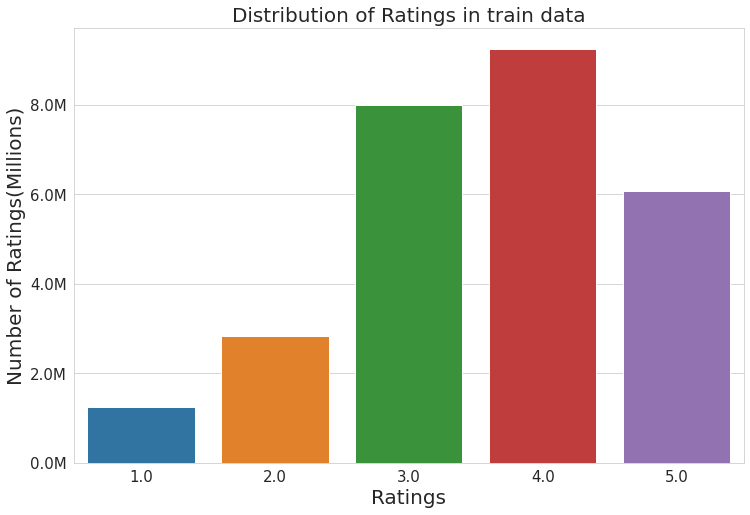

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=Train_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [ ]:
Train_Data["DayOfWeek"] = Train_Data.Date.dt.day_name()

In [ ]:
Train_Data.tail()

,MovieID,CustID,Ratings,Date,DayOfWeek
27390988,5571,1502020,3.0,2005-08-10,Wednesday
27390989,4740,921320,5.0,2005-08-10,Wednesday
27390990,15114,929499,4.0,2005-08-10,Wednesday
27390991,14137,680507,2.0,2005-08-10,Wednesday
27390992,5838,1904865,2.0,2005-08-10,Wednesday


**Number of Ratings Per Month**

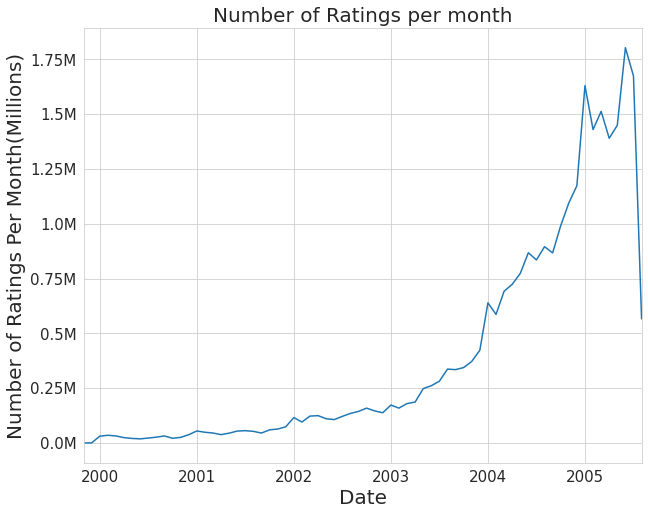

In [ ]:
plt.figure(figsize = (10,8))
ax = Train_Data.resample("M", on = "Date")["Ratings"].count().plot()
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

**Analysis of Rating Given by User**

In [ ]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

In [ ]:
no_of_rated_movies_per_user.head()

CustID
305344     5365
2439493    4951
387418     4831
1639792    3025
1461435    2970
Name: Ratings, dtype: int64

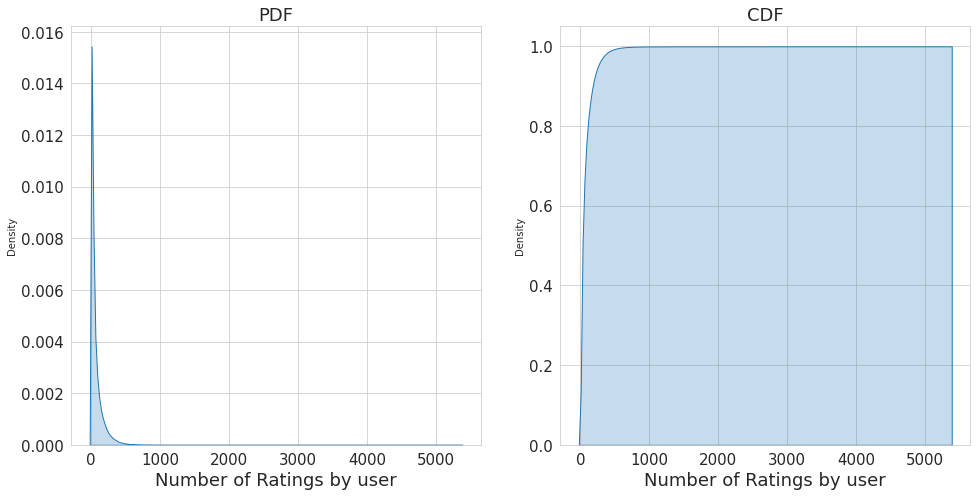

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [ ]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    398989.000000
mean         68.650998
std          97.022128
min           1.000000
25%          12.000000
50%          32.000000
75%          86.000000
max        5365.000000
Name: Ratings, dtype: float64

In [ ]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

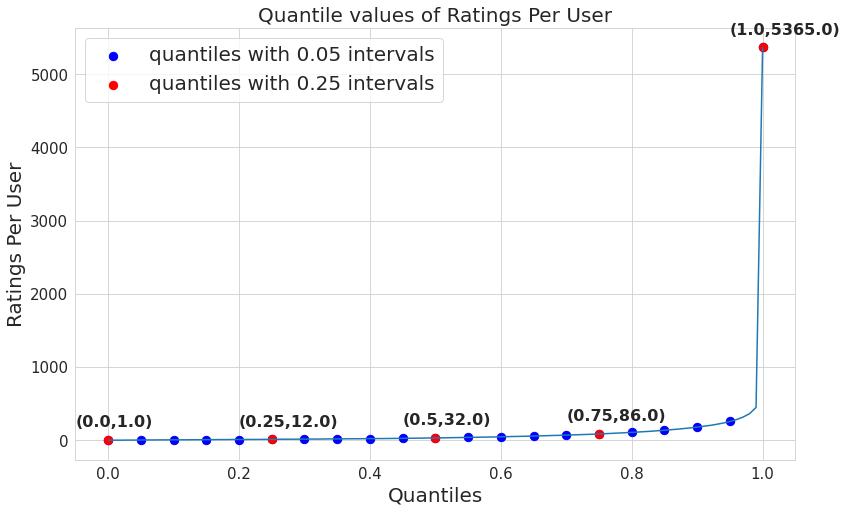

In [ ]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

In [ ]:
quantiles[::5]

0.00       1.0
0.05       3.0
0.10       6.0
0.15       8.0
0.20      10.0
0.25      12.0
0.30      15.0
0.35      18.0
0.40      22.0
0.45      26.0
0.50      32.0
0.55      39.0
0.60      47.0
0.65      57.0
0.70      70.0
0.75      86.0
0.80     107.0
0.85     136.0
0.90     180.0
0.95     256.0
1.00    5365.0
Name: Ratings, dtype: float64

In [ ]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 337460
Total number of ratings above 75th percentile = 61529


**Analysis of Rating Per Movie**

In [ ]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

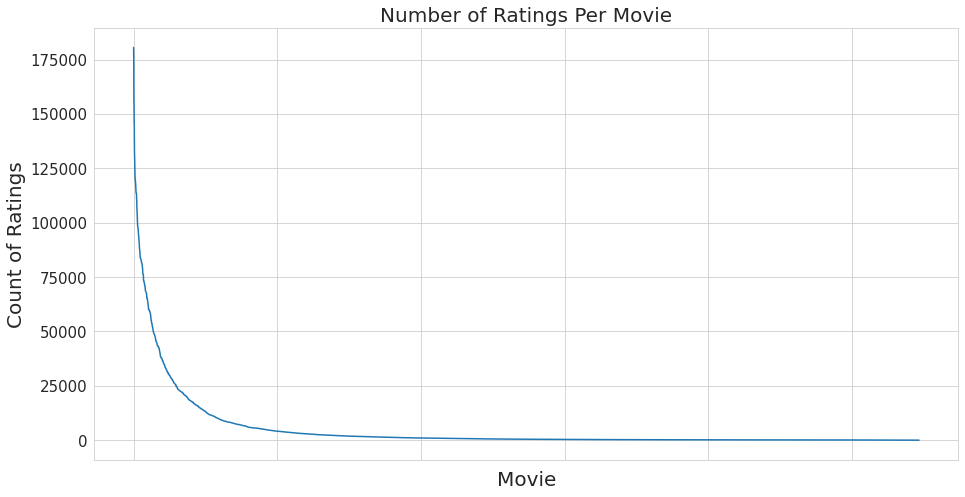

In [ ]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

**Analysis of Movie Ratings on Day of Week**

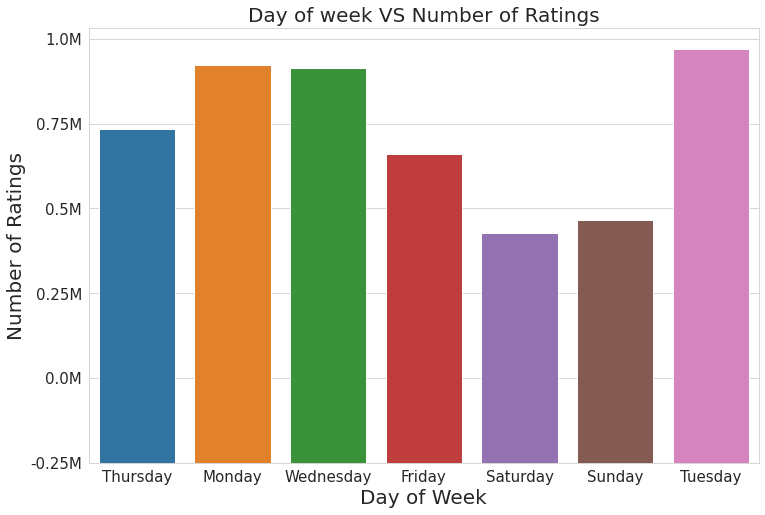

In [ ]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

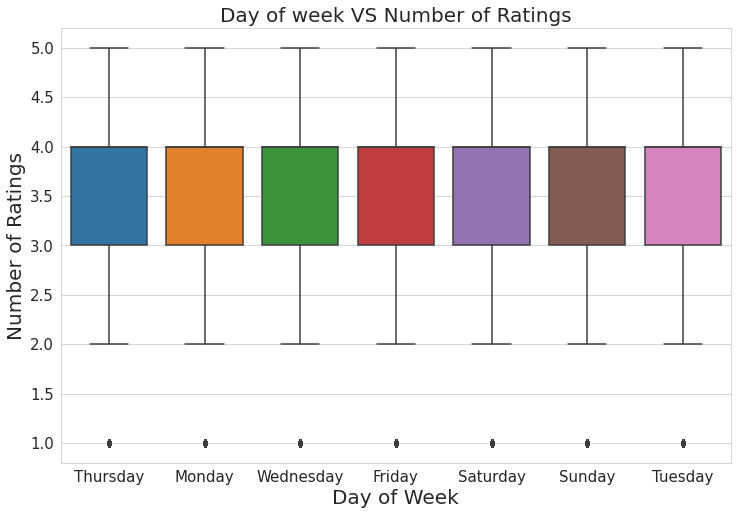

In [ ]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "DayOfWeek", y = "Ratings", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [ ]:
average_ratings_dayofweek = Train_Data.groupby(by = "DayOfWeek")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
DayOfWeek
Friday       3.593185
Monday       3.579076
Saturday     3.595584
Sunday       3.595782
Thursday     3.584425
Tuesday      3.577627
Wednesday    3.586706
Name: Ratings, dtype: float64


**Creating USER-ITEM sparse matrix from data frame**

In [ ]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 16119)
Saving it into disk for furthur usage.
Done

0:00:21.036105


In [ ]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 16119)
Saving it into disk for furthur usage.
Done

0:00:05.872045


In [ ]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.93586173140315% 


In [ ]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.9839654310946% 


**Finding Global average of all movie ratings, Average rating per user, and Average rating per movie**

In [ ]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

**Global Average Rating**

In [ ]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.5861370925836824


**Average Rating Per User**

In [ ]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

In [ ]:
print("Average rating of user 25 = {}".format(AvgRatingUser[921320]))

Average rating of user 25 = 4.0638297872340425


**Average Rating Per Movie**

In [ ]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

In [ ]:
print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))

Average rating of movie 4500 = 3.2831858407079646


**PDF and CDF of Average Ratings of Users and Movies**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


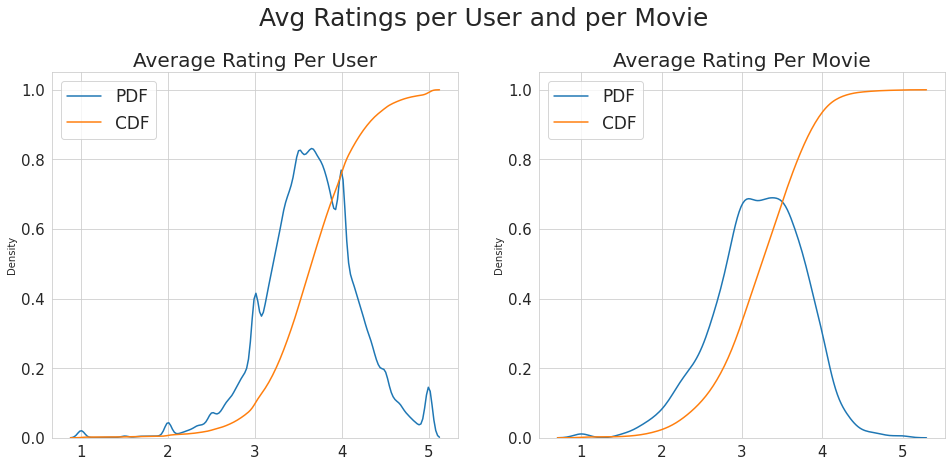

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

**Cold Start Problem**

**Cold Start Problem with Users**

In [ ]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 476557
Number of Users in train data= 398989
Number of Users not present in train data = 77568(16.0%)


**Cold Start Problem with Movies**

In [ ]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 5583
Number of Movies in train data= 5467
Number of Movies not present in train data = 116(2.0%)


**Computing Similarity Matrices**

**Computing User-User Similarity Matrix**

In [ ]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i)

6
7
10
33
42
59
79
83
87
94
97
131
134
142
149
158
168
169
178
183
188
189
192
195
199
201
242
247
248
261
265
266
267
268
283
291
296
298
299
301
302
304
305
307
308
310
312
314
330
331
333
352
363
368
369
379
383
384
385
392
413
416
424
437
439
440
442
453
462
470
471
477
478
481
485
490
491
492
495
508
515
517
527
529
536
540
544
546
550
561
576
585
592
596
602
609
614
616
623
633


In [ ]:
#Here, we are calculating user-user similarity matrix only for first 60 users in our sparse matrix. And we are calculating 
#top 60 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 60):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  
    rows = np.unique(row_index)
    similarMatrix = np.zeros(37020).reshape(617,60)    
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Time elapsed for 20 users = 0:00:22.229669sec
Time elapsed for 40 users = 0:00:43.005836sec
Time elapsed for 60 users = 0:01:03.008401sec
Average Time taken to compute similarity matrix for 1 user = 1.0321141282717388seconds


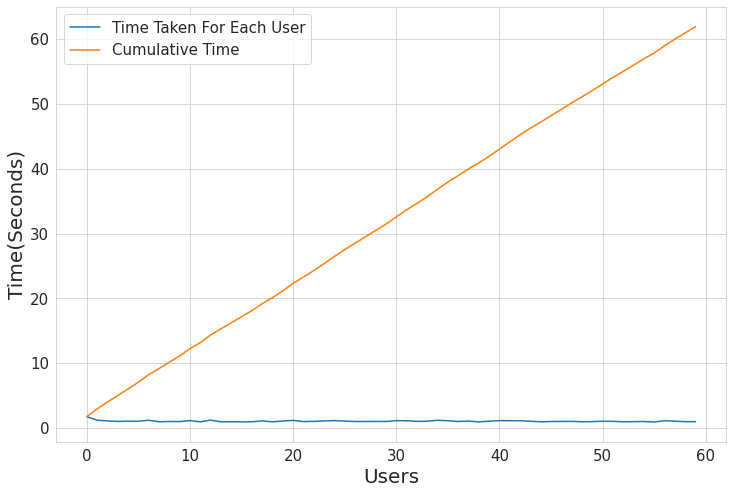

In [ ]:
simMatrix = getUser_UserSimilarity(TrainUISparseData, 60)

**Computing Movie-Movie Similarity Matrix**

In [ ]:
start = datetime.now()

if not os.path.isfile("m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
Done
Dimension of Matrix = (16119, 16119)
Storing the Movie Similarity matrix on disk for further usage
0:01:02.188521


**Does Movie-Movie Similarity Works?**

**Let's pick random movie and check it's top 10 most similar movies.**

In [ ]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [ ]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [ ]:
movie_titles_df = pd.read_csv("movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")

In [ ]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


**Similar Movies to: Godzilla's Revenge**

In [ ]:
movieID_GR = 14660

print("Name of the movie -------> "+str(movie_titles_df.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> The Waterboy
Number of ratings by users for movie The Waterboy is 83696
Number of similar movies to The Waterboy is 5453


In [ ]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

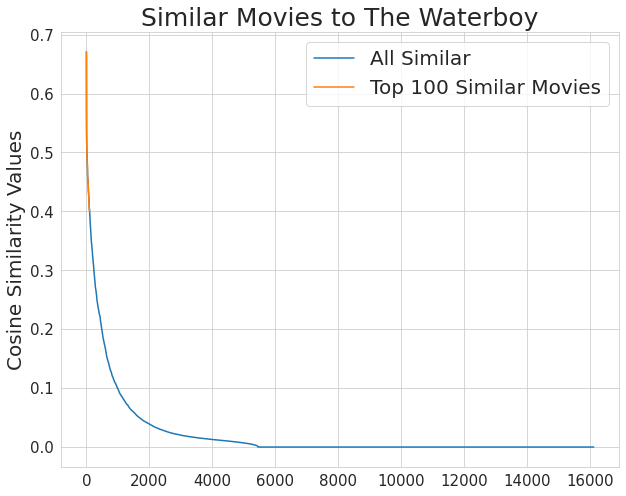

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to The Waterboy", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

**Top 10 Similar Movies to: The Waterboy**

In [ ]:
movie_titles_df.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
15393,1999.0,Big Daddy
5318,1995.0,Tommy Boy
14725,1999.0,Austin Powers: The Spy Who Shagged Me
5628,1996.0,The Nutty Professor
6833,1995.0,Billy Madison
4661,1999.0,Deuce Bigalow: Male Gigolo
6971,1986.0,Ferris Bueller's Day Off
6844,2001.0,The Fast and the Furious
6350,1998.0,Rush Hour


**Machine Learning Models**

In [ ]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

**Creating Sample Sparse Matrix for Train Data**

In [ ]:
path = "TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2649405, 16108)
0:07:46.954156


**Creating Sample Sparse Matrix for Test Data**

In [ ]:
path = "TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2648584, 16109)
0:08:43.312968


**Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)**

In [ ]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.61


**Finding Average of all movie ratings**

In [ ]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average move rating for movie 6007 is {}".format(globalAvgMovies[6007]))

Average move rating for movie 6007 is 4.298611111111111


**Finding Average rating per User**

In [ ]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 16879 is {}".format(globalAvgMovies[6007]))

Average user rating for user 16879 is 4.298611111111111


**Featurizing data**

In [ ]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 22592
No of ratings in Our Sampled test matrix is : 1575


**Featurizing data for regression problem**

**Featurizing Train Data**

In [ ]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [ ]:
if os.path.isfile("Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)  
            row.append(movie) 
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#Ratings given to "movie" by top 5 similar users with "user"
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            row.extend(top_similar_user_ratings)
            
 #Ratings given by "user" to top 5 similar movies with "movie"
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            row.extend(top_similar_movie_ratings)
            
 #Appending "user" average, "movie" average & rating of "user""movie"
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            
#Converting rows and appending them as comma separated values to csv file
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

Preparing Train csv file for 22592 rows
Done for 2000. Time elapsed: 0:06:33.700922
Done for 4000. Time elapsed: 0:13:00.886032
Done for 6000. Time elapsed: 0:19:26.346143
Done for 8000. Time elapsed: 0:25:54.186842
Done for 10000. Time elapsed: 0:32:36.172063
Done for 12000. Time elapsed: 0:39:15.012551
Done for 14000. Time elapsed: 0:46:03.555869
Done for 16000. Time elapsed: 0:52:48.887253
Done for 18000. Time elapsed: 0:59:30.883046
Done for 20000. Time elapsed: 1:06:07.458864
Done for 22000. Time elapsed: 1:12:40.312736
Total Time for 22592 rows = 1:14:35.445149


In [ ]:
Train_Reg = pd.read_csv("Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,2630,4546,3.609641,4.0,5.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.000000,3.450495,4.0
1,14827,4546,3.609641,4.0,5.0,4.0,4.0,4.0,2.0,3.0,3.0,3.0,3.0,3.000000,3.450495,4.0
2,18843,4546,3.609641,3.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,3.0,4.0,3.714286,3.450495,4.0
3,28172,4546,3.609641,3.0,5.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,3.636364,3.450495,3.0
4,31375,4546,3.609641,2.0,3.0,3.0,4.0,3.0,4.0,2.5,2.5,2.5,2.5,2.500000,3.450495,1.0


In [ ]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [ ]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (22592, 16)


**Featurizing Test Data**

In [ ]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [ ]:
if os.path.isfile("Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)  
            row.append(movie) 
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) 

#Ratings given to "movie" by top 5 similar users with "user"
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                row.extend(top_similar_user_ratings)
            #Cold Start Problem, for a new user or a new movie  
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #Ratings given by "user" to top 5 similar movies with "movie"
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                row.extend(top_similar_movie_ratings)
            #Cold Start Problem, for a new user or a new movie
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #Appending "user" average, "movie" average & rating of "user""movie"
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#Converting rows and appending them as comma separated values to csv file
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 1575 rows
Done for 100. Time elapsed: 0:00:22.727795
Done for 200. Time elapsed: 0:00:45.368080
Done for 300. Time elapsed: 0:01:07.814665
Done for 400. Time elapsed: 0:01:30.616506
Done for 500. Time elapsed: 0:01:52.807882
Done for 600. Time elapsed: 0:02:15.899467
Done for 700. Time elapsed: 0:02:39.216785
Done for 800. Time elapsed: 0:03:02.365290
Done for 900. Time elapsed: 0:03:24.897105
Done for 1000. Time elapsed: 0:03:47.927290
Done for 1100. Time elapsed: 0:04:11.007633
Done for 1200. Time elapsed: 0:04:34.239245
Done for 1300. Time elapsed: 0:04:57.386191
Done for 1400. Time elapsed: 0:05:20.400621
Done for 1500. Time elapsed: 0:05:43.264819
Total Time for 1575 rows = 0:06:00.443123


In [ ]:
Test_Reg = pd.read_csv("Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,1711346,4509,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,5.0
1,1858305,4509,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,4.0
2,1970677,4509,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,5.0
3,2231476,4556,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,5.0
4,13210,4633,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,3.609641,5.0


In [ ]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [ ]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (1575, 16)


**Transforming Data for Surprise Models**

**Transforming Train Data**

In [ ]:
Train_Reg[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,2630,4546,4.0
1,14827,4546,4.0
2,18843,4546,4.0
3,28172,4546,3.0
4,31375,4546,1.0


In [ ]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

**Transforming Test Data**

In [ ]:
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

In [ ]:
testset[:5]

[(1711346, 4509, 5.0),
 (1858305, 4509, 4.0),
 (1970677, 4509, 5.0),
 (2231476, 4556, 5.0),
 (13210, 4633, 5.0)]

**Applying Machine Learning Models**

In [ ]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [ ]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

**Utility Functions for Surprise Models**

In [ ]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [ ]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [ ]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#Evaluating Train Data
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#Evaluating Test Data
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

**Matrix Factorization SVD**

**Cross Validation**

In [ ]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9537528111892492
{'n_factors': 10}


**Applying SVD with best parameters**

In [ ]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8516243843145302
MAPE = 26.111603596832445
--------------------------------------------------
TEST DATA
RMSE = 1.0252973858914736
MAPE = 29.323828141846164
--------------------------------------------------
Time Taken = 0:00:00.748935


**Matrix Factorization SVDpp with implicit feedback**

**Cross Validation**

In [ ]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9472324682509049
{'n_factors': 10, 'lr_all': 0.006}


**Applying SVDpp with best parameters**

In [ ]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.771695465956741
MAPE = 23.214208659992885
--------------------------------------------------
TEST DATA
RMSE = 1.0254661331307358
MAPE = 29.31733665251281
--------------------------------------------------
Time Taken = 0:00:06.119709
